# Настройка


---

**Содержание:**
> Конвертация SESSIONS

>> Логика выбора условий для SESSIONS

>> Обработка столбцов и строк SESSIONS

> Конвертация TRACKS

> Конвертация PERSONS

> Комбинация данных

>> Создание связки (Пользователь - Название трека - Индекс трека - Автор)

>> Датасет для обучения

>> На случай, если понадобятся полные данные

> Конвертация USERS



---

**Примечание:** 

Данные. 30Music Dataset.

Часть 1. Подготовка данных. Конвертация idomaar. 

Часть 2. Recomdendation Artist. 


















Подключаем библиотеки

In [ ]:
import os, sys, csv, json, ast
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#!wget -P /content/download/ https://polimi365-my.sharepoint.com/personal/10322330_polimi_it/_layouts/15/onedrive.aspx?id=%2Fpersonal%2F10322330%5Fpolimi%5Fit%2FDocuments%2FArchivio%20Lavoro%20Repo%20e%20Dati%2FData%20linked%20on%20website%20DEIB%2FThirtyMusic%2Etar%2Egz&parent=%2Fpersonal%2F10322330%5Fpolimi%5Fit%2FDocuments%2FArchivio%20Lavoro%20Repo%20e%20Dati%2FData%20linked%20on%20website%20DEIB&originalPath=aHR0cHM6Ly9wb2xpbWkzNjUtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvMTAzMjIzMzBfcG9saW1pX2l0L0VmYnhfTEw5Q0pOSHExNjI1SnVIZTRVQlFuR2JSZzFGSGpMS1UxRWdtUmhYd0E_cnRpbWU9X1BoVG1GVU8yRWc #add link

--2020-06-11 22:25:34--  https://polimi365-my.sharepoint.com/personal/10322330_polimi_it/_layouts/15/onedrive.aspx?id=%2Fpersonal%2F10322330%5Fpolimi%5Fit%2FDocuments%2FArchivio%20Lavoro%20Repo%20e%20Dati%2FData%20linked%20on%20website%20DEIB%2FThirtyMusic%2Etar%2Egz
Resolving polimi365-my.sharepoint.com (polimi365-my.sharepoint.com)... 13.107.136.9
Connecting to polimi365-my.sharepoint.com (polimi365-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-06-11 22:25:35 ERROR 403: Forbidden.



Датасет закачивался вручную, но есть идея сделать это кодом + распаковка и удаление исходников.

Отсутствуют некоторые значения в изначальном наборе данных.

In [ ]:
def _column_names(j, columns):
    for i in columns:
        j[i] = 0

# Конвертация SESSIONS

Вот такая информация в данных: 

`event.session	287145	1390241844	{"numtracks":11,"playtime":2907} {"subjects":[{"type":"user","id":44361}],"objects":[{"type":"track","id":455834,"playstart":0,"playtime":239,"playratio":1.01,"action":"play"}`


**Playstart откинем, так как для анализа этот параметр не важен. Также для анализа не важен параметр playratio, но перед тем как его откинуть, рассчитаем среднее значение, чтобы убрать не популярные композиции в наборе данных**


Оценим значения треков, чтобы отклонить не нужное для рекомендации. Коэффициент вопроизведения указывает на популярность трека. Если он слишком низок, то музыка редко прослушивается. Если остуствует, тогда мы не можим судить об этом. Время прослушивания. И действие, как пропуск - значенит музыка не заинтересовала пользователя. Неизвестное действие, не говорит о качестве музыки, его мы оставим. (временно)


Чтобы отбросить не популярные данные для рекомендательного алгоритма, воспользуемся значением медианы, потому что:  

"*Предположим, что в одной комнате оказалось 19 бедняков и один миллионер. У каждого бедняка есть 5 ₽, а у миллионера — 1 млн ₽ (106). В сумме получается 1 000 095 ₽. Если мы разделим деньги равными долями на 20 человек, то получим 50 004,75 ₽. Это будет среднее арифметическое значение суммы денег, которая была у всех 20 человек в этой комнате.*

*Медиана в этом случае будет равна 5 ₽ (полусумма десятого и одиннадцатого, срединных значений ранжированного ряда). Можно интерпретировать это следующим образом. Разделив всю компанию на две равные группы по 10 человек, мы можем утверждать, что в первой группе у каждого не больше 5 ₽, во второй же — не меньше 5 ₽. В общем случае можно сказать, что медиана — это то, сколько принёс с собой «средний» человек. Наоборот, среднее арифметическое — неподходящая характеристика, так как оно значительно превышает сумму наличных, имеющуюся у среднего человека."*

Предварительный анализ показал, что значения Play_Ratio ниже 1 нас не интересуют, т.к значение воспроизведений в этом случае меньше 1 воспроизведения, при этом оставим неизвестные значения.

In [ ]:
!unzip /content/sessions.idomaar.zip

Archive:  /content/sessions.idomaar.zip
  inflating: sessions.idomaar        
  inflating: __MACOSX/._sessions.idomaar  


In [ ]:
#Перезаписываем файл во избежания ошибок
sessions = pd.read_csv('/content/sessions.idomaar', sep='	', header=None)

In [ ]:
#Название столбцов
ses_col_names = ['Num_Tracks','Play_Time', 'User_ID','Action', 'Play_Ratio','Track_Play_Time', 'Track_Recommend','Track_Non_Recommend']
_column_names(sessions, ses_col_names)

In [ ]:
#Без учета данных от playratio
#data_sessions = []
#for i in sessions[3]:
  #i = i.split(' ')
  #data_sessions_byte = []
  #track_id = []
  #bad_track_id = []
  #data_sessions_byte.append(ast.literal_eval(i[0])['numtracks'])
  #data_sessions_byte.append(ast.literal_eval(i[0])['playtime'])
  #data_sessions_byte.append(json.loads(i[1])['subjects'][0]['id'])
  #data_sessions_byte.append(json.loads(i[1])['objects'][0]['action'])
  #data_sessions_byte.append(json.loads(i[1])['objects'][0]['playratio'])
  #data_sessions_byte.append(json.loads(i[1])['objects'][0]['playtime'])
  #for track in json.loads(i[1])['objects']:
    #if track['action'] == 'skip' or track['playtime'] < 87.0 or track['playtime'] > 363.0:
      #bad_track_id.append(track['id']) #non range for playtime track and skip is not recommended expirence for user, none is not bad expirence. 
    #elif track['playtime'] >= 87.0 and track['playtime'] <= 363.0:
      #track_id.append(track['id']) #good expirence to recommend
    #elif track['action'] is None:
      #track_id.append(track_id.pop())
  #data_sessions_byte.append(track_id) 
  #data_sessions_byte.append(bad_track_id)
  #data_sessions.append(data_sessions_byte)

#С учетом данных от playratio, разделитель 1, потому что это медиана playratio в общем числе данных
data_sessions = []
for i in sessions[3]:
  i = i.split(' ')
  data_sessions_byte = []
  track_id = []
  bad_track_id = []
  data_sessions_byte.append(ast.literal_eval(i[0])['numtracks'])
  data_sessions_byte.append(ast.literal_eval(i[0])['playtime'])
  data_sessions_byte.append(json.loads(i[1])['subjects'][0]['id'])
  data_sessions_byte.append(json.loads(i[1])['objects'][0]['action'])
  data_sessions_byte.append(json.loads(i[1])['objects'][0]['playratio'])
  data_sessions_byte.append(json.loads(i[1])['objects'][0]['playtime'])
  for track in json.loads(i[1])['objects']:
    if track['playratio'] is not None:
      if track['action'] == 'skip' or track['playtime'] < 87.0 or track['playtime'] > 363.0 or track['playratio'] < 1.0:
        bad_track_id.append(track['id']) #non range for playtime track and skip is not recommended expirence for user, none is not bad expirence. play ratio < 1.0 is bad expirence
      elif track['playtime'] >= 87.0 and track['playtime'] <= 363.0 and track['playratio'] >= 1.0:
        track_id.append(track['id']) #good expirence to recommend
      elif track['action'] is None:
        track_id.append(track_id.pop())
    elif track['playratio'] is None:
      if track['action'] == 'skip' or track['playtime'] < 87.0 or track['playtime'] > 363.0:
        bad_track_id.append(track['id']) #non range for playtime track and skip is not recommended expirence for user, none is not bad expirence. play ratio < 1.0 is bad expirence
      elif track['playtime'] >= 87.0 and track['playtime'] <= 363.0:
        track_id.append(track['id']) #good expirence to recommend
      elif track['action'] is None:
        track_id.append(track_id.pop())
  data_sessions_byte.append(track_id) 
  data_sessions_byte.append(bad_track_id)
  data_sessions.append(data_sessions_byte)

In [ ]:
sessions[ses_col_names] = data_sessions

Логика диапазона (87, 363). Посчитали плотность распределения вероятностей и среднеквадратичную дисперсию. Выделили из этого необходимый диапазон, и по нему разбили данные для рекомендованных. Установим верхний диапазон, чтобы отсеять редкие результаты. 

## Логика выбора условий для SESSIONS

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Standard_deviation_diagram_%28decimal_comma%29.svg/325px-Standard_deviation_diagram_%28decimal_comma%29.svg.png)

Наблюдение `sessions[sessions["Play_Time"] < 0]`, если сессия имеет игровое время < 0, тогда многие данные содержат NaN,а время игры трека -1 эти данные нужно отбросить.




In [ ]:
#Ход действий получения диапазона.

In [ ]:
#Отфильтруем данные
calculation = sessions.loc[sessions['Track_Play_Time'] > 0]

In [ ]:
calculation.head()

,0,1,2,3,Num_Tracks,Play_Time,User_ID,Action,Play_Ratio,Track_Play_Time,Track_Recommend,Track_Non_Recommend
0,event.session,287144,1390231051,"{""numtracks"":23,""playtime"":4547} {""subjects"":[...",23,4547,44361,play,NaN,58,"[838286, 2746740, 3873988, 1778345, 4698875, 2...","[4698874, 2588097, 808046, 2588498, 2492893, 2..."
1,event.session,287145,1390241844,"{""numtracks"":11,""playtime"":2907} {""subjects"":[...",11,2907,44361,play,1.01,239,"[2460503, 1999451, 4698882, 2503246]","[455834, 3257000, 2765459, 1311408, 3439451, 3..."
2,event.session,287146,1390303249,"{""numtracks"":16,""playtime"":3191} {""subjects"":[...",16,3191,44361,play,NaN,198,"[118991, 1083663, 1316202, 1083664]","[4698883, 1299602, 1907900, 1646559, 3776691, ..."
3,event.session,287147,1390481828,"{""numtracks"":5,""playtime"":1162} {""subjects"":[{...",5,1162,44361,play,1.00,648,[2503252],"[1329082, 1066876, 4678485, 1876964]"
4,event.session,287140,1421443687,"{""numtracks"":2,""playtime"":250} {""subjects"":[{""...",2,250,42773,play,0.98,251,[3770848],[375509]


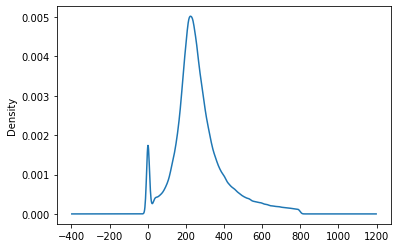

In [ ]:
#Нормальное распределение вероятностей. Возьмем максимальное значение плотности +- среднеквадратичного отклонения
ax = calculation['Track_Play_Time'].plot.kde()

In [ ]:
ax.axis('scaled') #У нас есть четыре значения, это начало и конец диапазона, а также самая высокая и низкая точка

(-477.8, 1277.8, -0.00025080146374067307, 0.005266830738554134)

In [ ]:
l = ax.get_children()[0].get_path()
l = l.vertices

In [ ]:
dfObj = pd.DataFrame(l)

In [ ]:
dfObj.loc[dfObj[1] > 0.005] #225 середина данных +- 138 - это наш диапазон для медианы времени прослушивания

,0,1
387,220.270270,0.005002
388,221.867868,0.005011
389,223.465465,0.005015
390,225.063063,0.005016
391,226.660661,0.005014
392,228.258258,0.005009
393,229.855856,0.005001


In [ ]:
calculation = sessions.loc[sessions['Track_Play_Time'] > 87]
calculation = calculation.loc[sessions['Track_Play_Time'] < 363]

In [ ]:
print(calculation.median()) #233

1                  1.382030e+06
2                  1.409541e+09
Num_Tracks         8.000000e+00
Play_Time          1.760000e+03
User_ID            2.430800e+04
Play_Ratio         1.000000e+00
Track_Play_Time    2.330000e+02
dtype: float64


In [ ]:
#Очистим память
del calculation, dfObj, l, ax

## Обработка столбцов и строк SESSIONS

In [ ]:
sessions.head()

,0,1,2,3,Num_Tracks,Play_Time,User_ID,Action,Play_Ratio,Track_Play_Time,Track_Recommend,Track_Non_Recommend
0,event.session,287144,1390231051,"{""numtracks"":23,""playtime"":4547} {""subjects"":[...",23,4547,44361,play,NaN,58,"[838286, 2588097, 2746740, 3873988, 808046, 25...","[4698874, 1778345, 4698881]"
1,event.session,287145,1390241844,"{""numtracks"":11,""playtime"":2907} {""subjects"":[...",11,2907,44361,play,1.01,239,"[455834, 1999451, 3257000, 2765459, 1311408, 3...","[2460503, 4698882, 2503246, 249947]"
2,event.session,287146,1390303249,"{""numtracks"":16,""playtime"":3191} {""subjects"":[...",16,3191,44361,play,NaN,198,"[4698883, 1299602, 1907900, 1646559, 118991, 1...","[1316202, 888696, 1083664, 2897013]"
3,event.session,287147,1390481828,"{""numtracks"":5,""playtime"":1162} {""subjects"":[{...",5,1162,44361,play,1.00,648,"[1329082, 1066876, 4678485]","[2503252, 1876964]"
4,event.session,287140,1421443687,"{""numtracks"":2,""playtime"":250} {""subjects"":[{""...",2,250,42773,play,0.98,251,[3770848],[375509]


Удалим не нужные столбцы и строки

In [ ]:
#Сессии в которых не прослушали ни одну песню 
sessions = sessions[sessions['Play_Time'] > 0]
#Колличество прослушанных треков на этом этапе не фильтруем

In [ ]:
sessions = sessions[[1,2,'Num_Tracks','Play_Time', 'User_ID', 'Track_Recommend','Track_Non_Recommend']]

Переименуем столбцы, когда получим все данные

In [ ]:
sessions.to_csv('sessions.csv', index = False)

In [ ]:
#Очистим память
del sessions

# Конвертация TRACKS

Вот такая информация в данных: 

`track	0	-1	{"duration":-1,"playcount":4,"MBID":null,"name":"000003+Music+Instructor/_/Dj%27s+Rock+Da+House+%C3%82%E2%89%88%C3%86%E2%89%88%C3%8A01+-+Dj+Max-Pulemet+Vs.+Bomfunk+Mc%27s+-+Electro+Breakdance+party+1+%5B2000%5D+=+CD+ONE%C3%82%E2%89%88%C3%86%E2%89%88%C3%8A"}	{"artists":[{"type":"person","id":0}],"albums":[],"tags":[]}`


**tags, albums откинем, так как для анализа этот параметр не содержит важных данных.**

In [ ]:
!unzip /content/tracks.idomaar.zip

Archive:  /content/tracks.idomaar.zip
  inflating: tracks.idomaar          
  inflating: __MACOSX/._tracks.idomaar  


In [ ]:
#Перезаписываем файл
tracks = pd.read_csv('/content/tracks.idomaar', sep='	', header=None)[[1,3,4]] #1, 3, 4 столбец (исключили 2 столбец)

Очистим столбец с именами треков и назовем его

In [ ]:
Track_Name = tracks[3].str.split(':', 8, expand=True)[4].str.split('"', 8, expand=True).drop([0,2], axis = 1).rename(columns={1:"Track_Name"})

Очистим столбец с продолжительностью трека и назовем его

In [ ]:
Duration = tracks[3].str.split(':', 8, expand=True)[1].str.split(',', 2, expand=True).drop([1], axis = 1).rename(columns={0:"Duration"})

Очистим столбец с Play_Count и назовем его

In [ ]:
Play_Count = tracks[3].str.split(':', 8, expand=True)[2].str.split(',', 2, expand=True).drop([1], axis = 1).rename(columns={0:"Play_Count"})

Очистим столбец с MBID и назовем его

In [ ]:
MBID = tracks[3].str.split(':', 8, expand=True)[3].str.split(',', 2, expand=True).drop([1], axis = 1).rename(columns={0:"MBID"})

Вытяним данные для столбца с индексом авторов песен

In [ ]:
tracks['Author_ID'] = tracks.apply(lambda x: [author['id'] for author in ast.literal_eval(x[4].split('"albums"')[0]+'}')['artists']], axis=1)

Столбцы снова склеиваются, в том же порядке строк

In [ ]:
tracks_filter = pd.concat([tracks[1], Track_Name, Duration, Play_Count, tracks['Author_ID']], axis=1, sort=False).rename(columns={1:"Track_ID"})

In [ ]:
#Может стоит сделать флитрацию для Duration tracks_filter = tracks_filter[tracks_filter['Duration'] > 0]

In [ ]:
tracks_filter.to_csv('tracks.csv', index=False)

In [ ]:
#Очистим память
del tracks, tracks_filter, MBID, Play_Count, Duration, Track_Name

# Конвертация PERSONS 

In [ ]:
!unzip /content/persons.idomaar.zip

Archive:  /content/persons.idomaar.zip
  inflating: persons.idomaar         
  inflating: __MACOSX/._persons.idomaar  


In [ ]:
#Перезаписываем файл
persons = pd.read_csv('/content/persons.idomaar', sep='	', header=None)[[1,3]]

In [ ]:
persons['Name'] = persons.apply(lambda x: x[3].split('"name":')[1][:-1], axis=1)

In [ ]:
persons_filter = persons['Name'].str.split('"', 3, expand=True).drop([0,2], axis = 1).rename(columns={1:"Track_Name"})

In [ ]:
persons = pd.concat([persons[1], persons_filter], axis=1, sort=False)

In [ ]:
persons.to_csv('persons.csv', index=False)

In [ ]:
#Проверка! Оказалось, что колонка 1 - это имя Автора песни. Эти данные также содержаться и в track. Значит данный сет можно не применять. Либо можно было бы обрезать названия песен в сете треки, а потом востановить, при необходимости этим дата сетом 
persons.loc[persons[1] == 145148]

,1,Track_Name
0,145148,Everything+Is+Illuminated


In [ ]:
#Очистим память
del persons, persons_filter

# Комбинация данных

**Пункт 1.** В первую очередь нужно подготовить данные: перейти от истории прослушиваний треков к истории прослушивания исполнителей (полезные файлы: sessions, tracks, persons).

In [ ]:
!unzip /content/ThirtyMusicCSV.zip

Archive:  /content/ThirtyMusicCSV.zip
   creating: ThirtyMusicCSV/
  inflating: ThirtyMusicCSV/.DS_Store  
  inflating: __MACOSX/ThirtyMusicCSV/._.DS_Store  
   creating: ThirtyMusicCSV/relations/
   creating: ThirtyMusicCSV/entities/
  inflating: ThirtyMusicCSV/relations/sessions_is_ratio.csv  
  inflating: __MACOSX/ThirtyMusicCSV/relations/._sessions_is_ratio.csv  
  inflating: ThirtyMusicCSV/relations/.DS_Store  
  inflating: __MACOSX/ThirtyMusicCSV/relations/._.DS_Store  
  inflating: ThirtyMusicCSV/entities/tracks.csv  
  inflating: __MACOSX/ThirtyMusicCSV/entities/._tracks.csv  
  inflating: ThirtyMusicCSV/entities/users.csv  
  inflating: __MACOSX/ThirtyMusicCSV/entities/._users.csv  
  inflating: ThirtyMusicCSV/entities/persons.csv  
  inflating: __MACOSX/ThirtyMusicCSV/entities/._persons.csv  


Более общая векторизованная функция, которая будет работать для нескольких обычных и нескольких столбцов списка.

In [ ]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

Импортируем данные для первичной комбинации

In [ ]:
tracks = pd.read_csv('/content/ThirtyMusicCSV/entities/tracks.csv')
sessions = pd.read_csv('/content/ThirtyMusicCSV/relations/sessions_is_ratio.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Без этого много памяти сжирается, при обработке
sessions.Track_Recommend = sessions.Track_Recommend.apply(lambda x: ast.literal_eval(x))
sessions.Track_Non_Recommend = sessions.Track_Non_Recommend.apply(lambda x: ast.literal_eval(x))

Разделим данные в ячейках стобцов (explode), чтобы соединить данные отдельно с перехом индекса трека в индекс автора для рекомендумой музыки, и для не рекомендуемой (может пригодится, при оценки), при помощи merge. Дополительно, скомбинируем эти данные в один датасет (возможно понадобиться)

In [ ]:
sessions_recommend = sessions.drop('Track_Non_Recommend', axis = 1)
sessions_recommend = explode(sessions_recommend, ['Track_Recommend'], fill_value='0').astype(int)

In [ ]:
sessions_non_recommend = sessions.drop('Track_Recommend', axis = 1)
sessions_non_recommend = explode(sessions_non_recommend, ['Track_Non_Recommend'], fill_value='0').astype(int)

In [ ]:
tracks['Track_ID']=tracks['Track_ID'].astype(int)

In [ ]:
artist_recommended = pd.merge(sessions_recommend,tracks, left_on='Track_Recommend', right_on='Track_ID', how='left')

In [ ]:
artist_non_recommended = pd.merge(sessions_non_recommend,tracks, left_on='Track_Non_Recommend', right_on='Track_ID', how='left')

In [ ]:
artist_non_recommended.head()

,1,2,Num_Tracks,Play_Time,User_ID,Track_Non_Recommend,Track_ID,Track_Name,Duration,Play_Count,Author_ID
0,287144,1390231051,23,4547,44361,4698874,4698874,ZZ+Top/_/She+Loves+My+Automobile,null,null,[142266]
1,287144,1390231051,23,4547,44361,1778345,1778345,Maurice+Ravel/_/Alborada+del+gracioso,418000,2638,[223118]
2,287144,1390231051,23,4547,44361,2989691,2989691,The+Thermals/_/How+We+Know,196000,2296,[369980]
3,287144,1390231051,23,4547,44361,1728736,1728736,Maria+Callas/_/Un+bel+di+vedremo,280000,267,[216834]
4,287144,1390231051,23,4547,44361,2615446,2615446,Sophie+Hunger/_/1983,185000,48,[327617]


In [ ]:
#Clear RAM
del sessions, sessions_recommend, sessions_non_recommend, tracks

## Создание связки (Пользователь - Название трека - Индекс трека - Автор)

Данные могут понадобиться отдельно, и вместе. Соеденим строки с одним индексом пользователя. 

In [ ]:
#Датасет Пользоветль - Рекомендуемые авторы (Удалить повторяющиеся данные)
user_artists_id_recomended = artist_recommended.groupby('User_ID')['Author_ID'].agg(' '.join).reset_index()

In [ ]:
#Датасет Пользоветль - Не рекомендуемые авторы (Удалить повторяющиеся данные)
user_artists_id_non_recomended = artist_non_recommended.groupby('User_ID')['Author_ID'].agg(' '.join).reset_index()

In [ ]:
del artist_recommended, artist_non_recommended

In [ ]:
#Уберем не нужные символы
author_ID_check = user_artists_id_recomended['Author_ID'].str.replace('[','',regex=True).replace(']','',regex=True).apply(lambda s: ', '.join(set(s.split(' '))))

In [ ]:
#Перезапишем
id_recomended = pd.concat([user_artists_id_recomended['User_ID'], pd.DataFrame(author_ID_check)], axis=1)

In [ ]:
del user_artists_id_recomended, author_ID_check

In [ ]:
#Уберем не нужные символы
author_ID_check = user_artists_id_non_recomended['Author_ID'].str.replace('[','',regex=True).replace(']','',regex=True).apply(lambda s: ', '.join(set(s.split(' '))))

In [ ]:
#Перезапишем
id_non_recomended = pd.concat([user_artists_id_non_recomended['User_ID'], pd.DataFrame(author_ID_check)], axis=1)

In [ ]:
id_recomended = id_recomended.rename(columns={'Author_ID': 'Author_ID_Recommended'})
id_non_recomended = id_non_recomended.rename(columns={'Author_ID': 'Author_ID_Non_Recommended'})

In [ ]:
#Следующий шаг - переименовать стобцы и соединить данные (Объеденить повторяющиеся индексы слушаетелей)
artist_user = pd.merge(id_recomended,id_non_recomended, left_on='User_ID', right_on='User_ID', how='left')

In [ ]:
artist_user.to_csv('artist_user.csv', index=False)

In [ ]:
id_recomended.to_csv('id_recomended.csv', index=False)
id_non_recomended.to_csv('id_non_recomended.csv', index=False)

In [ ]:
del id_non_recomended, id_recomended, artist_user

## Датасет для обучения

С разделением для предсказаний. Создадим такой датасет, где к одной рекомендации будут соеденены все не рекомендованные, под индексом автора, чтобы в дальнейшем обучать на этих данных. Значение 0, означает отсуствие трека

In [ ]:
artist_recommended = artist_recommended.drop(columns=['1',	'2',	'Num_Tracks',	'Play_Time',	'Track_Recommend',	'Track_ID',	'Track_Name',	'Duration',	'Play_Count'], axis = 1).rename(columns={'Author_ID': 'Author_ID_Recommended'})

In [ ]:
#Уберем не нужные символы. Не воспроизводть шаги Пользователь - Название трека - Индекс трека - Автор
author_rec = artist_recommended['Author_ID_Recommended'].str.replace('[','',regex=True).replace(']','',regex=True).astype(int)

In [ ]:
#Перезапишем
id_recomended = pd.concat([artist_recommended['User_ID'], pd.DataFrame(author_rec)], axis=1)

In [ ]:
del artist_recommended, author_rec

In [ ]:
author_rec = artist_non_recommended['Author_ID_Non_Recommended'].str.replace('[','',regex=True).replace(']','',regex=True).astype(int)

In [ ]:
#Перезапишем
id_non_recomended = pd.concat([artist_non_recommended['User_ID'], pd.DataFrame(author_rec)], axis=1)

In [ ]:
del artist_non_recommended, author_rec

In [ ]:
len(id_recomended)

34211555

In [ ]:
len(id_non_recomended)

23961551

In [ ]:
id_recomended = pd.read_csv('/content/id_recomended.csv')
id_non_recomended = pd.read_csv('/content/id_non_recomended.csv')

In [ ]:
author_full = pd.merge(id_recomended,id_non_recomended, left_on='User_ID', right_on='User_ID', how='left')

## На случай, если понадобятся полные данные

Если мы захотим сохранить все данные

In [ ]:
#test
test = artist_recommended[:100000]

In [ ]:
#Переводим значения в строки (При рассчетах перевести обратно). Для такого объема данных понадобиться Apache Spark. Либо сократить колличество данных.
test['1'] = test['1'].astype(str)
test['2'] = test['2'].astype(str)
test['Track_Recommend'] = test['Track_Recommend'].astype(str)
test['Num_Tracks'] = test['Num_Tracks'].astype(str)
test['Play_Time'] = test['Play_Time'].astype(str)
test['Track_Name'] = test['Track_Name'].astype(str)
test['Duration'] = test['Duration'].astype(str)
test['Play_Count'] = test['Play_Count'].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
#Оставляем нужные столбцы
test = test.groupby('User_ID')['1',	'2',	'Num_Tracks',	'Play_Time',	'User_ID',	'Track_Recommend',	'Track_Name',	'Duration',	'Play_Count',	'Author_ID'].agg(', '.join).reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
#Deleted repeat values in cells
test['Num_Tracks'] = test['Num_Tracks'].apply(lambda s: ', '.join(set(s.split(', '))))
test['1'] = test['1'].apply(lambda s: ', '.join(set(s.split(', '))))
test['2'] = test['2'].apply(lambda s: ', '.join(set(s.split(', '))))
test['Play_Time'] = test['Play_Time'].apply(lambda s: ', '.join(set(s.split(', '))))
test['Track_Recommend'] = test['Track_Recommend'].apply(lambda s: ', '.join(set(s.split(', '))))
test['Duration'] = test['Duration'].apply(lambda s: ', '.join(set(s.split(', '))))
test['Play_Count'] = test['Play_Count'].apply(lambda s: ', '.join(set(s.split(', '))))
test['Author_ID'] = test['Author_ID'].apply(lambda s: ', '.join(set(s.split(', '))))

In [ ]:
#result for recommended tracks. maybe we will use duration of sessions or number tracks at the sometimes
test.head()

,User_ID,1,2,Num_Tracks,Play_Time,Track_Recommend,Track_Name,Duration,Play_Count,Author_ID
0,29,"2507596, 2507599, 2507592, 2507626","1399444814, 1399650658, 1399661236, 1421160724","6, 18, 11","3591, 1233, 2859, 3418","3426569, 1784354, 394272, 3577397, 902725, 357...","Beck/_/Heart+Is+a+Drum, Beck/_/Don%27t+Let+It+...","189000, 329000, 265000, 218000, 180000, 259000...","981, 891, 478, 2749, 2604, 1437, 13494, 143, 1...","[12464], [435700], [203795], [427962], [197674..."
1,63,"1320520, 1320525, 1320522, 1320526, 1320527, 1...","1402293722, 1402291466, 1402362736, 1402322100...","17, 85, 19, 4, 20, 12, 35, 9, 26","4699, 4284, 14179, 7992, 3621, 5437, 3347, 109...","0, 443142, 443377, 443242, 443431, 443192, 443...","Boards+of+Canada/_/A+Is+to+B+as+B+Is+to+C, Boa...","329000, 283000, 306000, 240000, 309000, -1, 32...","18, 5, 40, 1256, 23, 2025, 407, 671, 5597, 581...","[456649], [0], [154644], [53362]"
2,95,1942036,1396295756,21,6043,"3506722, 3506705, 3506715, 3506683, 3506975","Iced+Earth/_/Cast+In+Stone, Iced+Earth/_/Brain...","234000, 293000, 359000, 322000, 290000","3956, 268, 6475, 1, 11",[438248]
3,100,"2508178, 2508179, 2508170","1392987499, 1394577426, 1394906666","7, 5, 3","1059, 2812, 502","1400492, 430645, 1400494, 486618, 430652","Hamfer%C3%B0/_/Evst, Hamfer%C3%B0/_/At+jar%C3%...","258000, 244000, 246000, 349000, 177000","529, 631, 3211, 10093","[58041], [175853], [52230]"
4,157,1771251,1421177928,24,6233,"3690029, 3638704, 573131, 573023, 1420771, 369...","Carpenters/_/Yesterday+Once+More, Carpenters/_...","219000, 218000, 152000, 244000, 271000, 231000...","1111, 5851, 993, 881, 89, 29, 3, 1028, 412, 66...","[178595], [454340], [69123], [458950], [46151]"


# Конвертация USERS

In [ ]:
users = pd.read_csv('/content/users.idomaar', sep='	', header=None)[[1,3]]

In [ ]:
columns = list(ast.literal_eval(users.values[0][1]).keys())

In [ ]:
def _split(dict):
    dict = dict[1:-1].split(',')
    f = lambda token: np.nan if len(token) < 2 or token[1] in ['','""'] else token[1]   
    return [f(i.split(':')) for i in dict]

In [ ]:
_column_names(users, columns)
users[columns] = np.array(users.apply(lambda x: _split(x[3]), axis=1).values.tolist())
users['ID'] = users[1]
users.drop([1,3], axis=1, inplace = True)

In [ ]:
users.to_csv('users.csv', index=False)

In [ ]:
del users, columns